In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ADL/HW1

/content/drive/MyDrive/ADL/HW1


In [ ]:
!pip install datasets
!pip install evaluate
!pip install accelerate
!pip install huggingface_hub
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 103.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.

In [ ]:
import json
with open('context.json', 'r') as file:
  context_list = json.load(file)

In [ ]:
# coding=utf-8
# Copyright 2020 The HuggingFace Team All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
Post-processing utilities for question answering.
"""
import collections
import json
import logging
import os
from typing import Optional, Tuple

import numpy as np
from tqdm.auto import tqdm


logger = logging.getLogger(__name__)


def postprocess_qa_predictions(
    examples,
    features,
    predictions: Tuple[np.ndarray, np.ndarray],
    version_2_with_negative: bool = False,
    n_best_size: int = 20,
    max_answer_length: int = 30,
    null_score_diff_threshold: float = 0.0,
    output_dir: Optional[str] = None,
    prefix: Optional[str] = None,
    log_level: Optional[int] = logging.WARNING,
):
    """
    Post-processes the predictions of a question-answering model to convert them to answers that are substrings of the
    original contexts. This is the base postprocessing functions for models that only return start and end logits.

    Args:
        examples: The non-preprocessed dataset (see the main script for more information).
        features: The processed dataset (see the main script for more information).
        predictions (:obj:`Tuple[np.ndarray, np.ndarray]`):
            The predictions of the model: two arrays containing the start logits and the end logits respectively. Its
            first dimension must match the number of elements of :obj:`features`.
        version_2_with_negative (:obj:`bool`, `optional`, defaults to :obj:`False`):
            Whether or not the underlying dataset contains examples with no answers.
        n_best_size (:obj:`int`, `optional`, defaults to 20):
            The total number of n-best predictions to generate when looking for an answer.
        max_answer_length (:obj:`int`, `optional`, defaults to 30):
            The maximum length of an answer that can be generated. This is needed because the start and end predictions
            are not conditioned on one another.
        null_score_diff_threshold (:obj:`float`, `optional`, defaults to 0):
            The threshold used to select the null answer: if the best answer has a score that is less than the score of
            the null answer minus this threshold, the null answer is selected for this example (note that the score of
            the null answer for an example giving several features is the minimum of the scores for the null answer on
            each feature: all features must be aligned on the fact they `want` to predict a null answer).

            Only useful when :obj:`version_2_with_negative` is :obj:`True`.
        output_dir (:obj:`str`, `optional`):
            If provided, the dictionaries of predictions, n_best predictions (with their scores and logits) and, if
            :obj:`version_2_with_negative=True`, the dictionary of the scores differences between best and null
            answers, are saved in `output_dir`.
        prefix (:obj:`str`, `optional`):
            If provided, the dictionaries mentioned above are saved with `prefix` added to their names.
        log_level (:obj:`int`, `optional`, defaults to ``logging.WARNING``):
            ``logging`` log level (e.g., ``logging.WARNING``)
    """
    # print("preprocess_qa_examplea")
    # print(examples)
    # print('###')
    if len(predictions) != 2:
        raise ValueError("`predictions` should be a tuple with two elements (start_logits, end_logits).")
    all_start_logits, all_end_logits = predictions

    if len(predictions[0]) != len(features):
        raise ValueError(f"Got {len(predictions[0])} predictions and {len(features)} features.")

    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    all_predictions = collections.OrderedDict()
    all_nbest_json = collections.OrderedDict()
    if version_2_with_negative:
        scores_diff_json = collections.OrderedDict()

    # Logging.
    logger.setLevel(log_level)
    logger.info(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_prediction = None
        prelim_predictions = []

        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]
            # Optional `token_is_max_context`, if provided we will remove answers that do not have the maximum context
            # available in the current feature.
            token_is_max_context = features[feature_index].get("token_is_max_context", None)

            # Update minimum null prediction.
            feature_null_score = start_logits[0] + end_logits[0]
            if min_null_prediction is None or min_null_prediction["score"] > feature_null_score:
                min_null_prediction = {
                    "offsets": (0, 0),
                    "score": feature_null_score,
                    "start_logit": start_logits[0],
                    "end_logit": end_logits[0],
                }

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or len(offset_mapping[start_index]) < 2
                        or offset_mapping[end_index] is None
                        or len(offset_mapping[end_index]) < 2
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue
                    # Don't consider answer that don't have the maximum context available (if such information is
                    # provided).
                    if token_is_max_context is not None and not token_is_max_context.get(str(start_index), False):
                        continue

                    prelim_predictions.append(
                        {
                            "offsets": (offset_mapping[start_index][0], offset_mapping[end_index][1]),
                            "score": start_logits[start_index] + end_logits[end_index],
                            "start_logit": start_logits[start_index],
                            "end_logit": end_logits[end_index],
                        }
                    )
        if version_2_with_negative and min_null_prediction is not None:
            # Add the minimum null prediction
            prelim_predictions.append(min_null_prediction)
            null_score = min_null_prediction["score"]

        # Only keep the best `n_best_size` predictions.
        predictions = sorted(prelim_predictions, key=lambda x: x["score"], reverse=True)[:n_best_size]

        # Add back the minimum null prediction if it was removed because of its low score.
        if (
            version_2_with_negative
            and min_null_prediction is not None
            and not any(p["offsets"] == (0, 0) for p in predictions)
        ):
            predictions.append(min_null_prediction)

        # Use the offsets to gather the answer text in the original context.
        context = context_list[example["relevant"]]
        # print(context)

        for pred in predictions:

            offsets = pred.pop("offsets")
            # print("--offsets")
            # print(offsets)
            # print("--offsets")
            pred["text"] = context[offsets[0] : offsets[1]]

        # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
        # failure.
        if len(predictions) == 0 or (len(predictions) == 1 and predictions[0]["text"] == ""):
            predictions.insert(0, {"text": "empty", "start_logit": 0.0, "end_logit": 0.0, "score": 0.0})
            # print("preprocess_qa")
            # print(predictions)

        # Compute the softmax of all scores (we do it with numpy to stay independent from torch/tf in this file, using
        # the LogSumExp trick).
        scores = np.array([pred.pop("score") for pred in predictions])
        exp_scores = np.exp(scores - np.max(scores))
        probs = exp_scores / exp_scores.sum()

        # Include the probabilities in our predictions.
        for prob, pred in zip(probs, predictions):
            pred["probability"] = prob

        # print(predictions[0])

        # Pick the best prediction. If the null answer is not possible, this is easy.
        if not version_2_with_negative:
            # print(predictions[0]["text"])
            all_predictions[example["id"]] = predictions[0]["text"]
        else:
            # Otherwise we first need to find the best non-empty prediction.
            i = 0
            while predictions[i]["text"] == "":
                i += 1
            best_non_null_pred = predictions[i]

            # Then we compare to the null prediction using the threshold.
            score_diff = null_score - best_non_null_pred["start_logit"] - best_non_null_pred["end_logit"]
            scores_diff_json[example["id"]] = float(score_diff)  # To be JSON-serializable.
            if score_diff > null_score_diff_threshold:
                all_predictions[example["id"]] = ""
                # print("******")
            else:
                all_predictions[example["id"]] = best_non_null_pred["text"]

        # Make `predictions` JSON-serializable by casting np.float back to float.
        all_nbest_json[example["id"]] = [
            {k: (float(v) if isinstance(v, (np.float16, np.float32, np.float64)) else v) for k, v in pred.items()}
            for pred in predictions
        ]

    # If we have an output_dir, let's save all those dicts.
    if output_dir is not None:
        if not os.path.isdir(output_dir):
            raise EnvironmentError(f"{output_dir} is not a directory.")

        prediction_file = os.path.join(
            output_dir, "predictions.json" if prefix is None else f"{prefix}_predictions.json"
        )
        nbest_file = os.path.join(
            output_dir, "nbest_predictions.json" if prefix is None else f"{prefix}_nbest_predictions.json"
        )
        if version_2_with_negative:
            null_odds_file = os.path.join(
                output_dir, "null_odds.json" if prefix is None else f"{prefix}_null_odds.json"
            )

        logger.info(f"Saving predictions to {prediction_file}.")
        with open(prediction_file, "w") as writer:
            writer.write(json.dumps(all_predictions, indent=4) + "\n")
        logger.info(f"Saving nbest_preds to {nbest_file}.")
        with open(nbest_file, "w") as writer:
            writer.write(json.dumps(all_nbest_json, indent=4) + "\n")
        if version_2_with_negative:
            logger.info(f"Saving null_odds to {null_odds_file}.")
            with open(null_odds_file, "w") as writer:
                writer.write(json.dumps(scores_diff_json, indent=4) + "\n")
    # print(all_predictions)
    return all_predictions


# def postprocess_qa_predictions_with_beam_search(
#     examples,
#     features,
#     predictions: Tuple[np.ndarray, np.ndarray],
#     version_2_with_negative: bool = False,
#     n_best_size: int = 20,
#     max_answer_length: int = 30,
#     start_n_top: int = 5,
#     end_n_top: int = 5,
#     output_dir: Optional[str] = None,
#     prefix: Optional[str] = None,
#     log_level: Optional[int] = logging.WARNING,
# ):
#     """
#     Post-processes the predictions of a question-answering model with beam search to convert them to answers that are substrings of the
#     original contexts. This is the postprocessing functions for models that return start and end logits, indices, as well as
#     cls token predictions.

#     Args:
#         examples: The non-preprocessed dataset (see the main script for more information).
#         features: The processed dataset (see the main script for more information).
#         predictions (:obj:`Tuple[np.ndarray, np.ndarray]`):
#             The predictions of the model: two arrays containing the start logits and the end logits respectively. Its
#             first dimension must match the number of elements of :obj:`features`.
#         version_2_with_negative (:obj:`bool`, `optional`, defaults to :obj:`False`):
#             Whether or not the underlying dataset contains examples with no answers.
#         n_best_size (:obj:`int`, `optional`, defaults to 20):
#             The total number of n-best predictions to generate when looking for an answer.
#         max_answer_length (:obj:`int`, `optional`, defaults to 30):
#             The maximum length of an answer that can be generated. This is needed because the start and end predictions
#             are not conditioned on one another.
#         start_n_top (:obj:`int`, `optional`, defaults to 5):
#             The number of top start logits too keep when searching for the :obj:`n_best_size` predictions.
#         end_n_top (:obj:`int`, `optional`, defaults to 5):
#             The number of top end logits too keep when searching for the :obj:`n_best_size` predictions.
#         output_dir (:obj:`str`, `optional`):
#             If provided, the dictionaries of predictions, n_best predictions (with their scores and logits) and, if
#             :obj:`version_2_with_negative=True`, the dictionary of the scores differences between best and null
#             answers, are saved in `output_dir`.
#         prefix (:obj:`str`, `optional`):
#             If provided, the dictionaries mentioned above are saved with `prefix` added to their names.
#         log_level (:obj:`int`, `optional`, defaults to ``logging.WARNING``):
#             ``logging`` log level (e.g., ``logging.WARNING``)
#     """
#     if len(predictions) != 5:
#         raise ValueError("`predictions` should be a tuple with five elements.")
#     start_top_log_probs, start_top_index, end_top_log_probs, end_top_index, cls_logits = predictions

#     if len(predictions[0]) != len(features):
#         raise ValueError(f"Got {len(predictions[0])} predictions and {len(features)} features.")

#     # Build a map example to its corresponding features.
#     example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
#     features_per_example = collections.defaultdict(list)
#     for i, feature in enumerate(features):
#         features_per_example[example_id_to_index[feature["example_id"]]].append(i)

#     # The dictionaries we have to fill.
#     all_predictions = collections.OrderedDict()
#     all_nbest_json = collections.OrderedDict()
#     scores_diff_json = collections.OrderedDict() if version_2_with_negative else None

#     # Logging.
#     logger.setLevel(log_level)
#     logger.info(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

#     # Let's loop over all the examples!
#     for example_index, example in enumerate(tqdm(examples)):
#         # Those are the indices of the features associated to the current example.
#         feature_indices = features_per_example[example_index]

#         min_null_score = None
#         prelim_predictions = []

#         # Looping through all the features associated to the current example.
#         for feature_index in feature_indices:
#             # We grab the predictions of the model for this feature.
#             start_log_prob = start_top_log_probs[feature_index]
#             start_indexes = start_top_index[feature_index]
#             end_log_prob = end_top_log_probs[feature_index]
#             end_indexes = end_top_index[feature_index]
#             feature_null_score = cls_logits[feature_index]
#             # This is what will allow us to map some the positions in our logits to span of texts in the original
#             # context.
#             offset_mapping = features[feature_index]["offset_mapping"]
#             # Optional `token_is_max_context`, if provided we will remove answers that do not have the maximum context
#             # available in the current feature.
#             token_is_max_context = features[feature_index].get("token_is_max_context", None)

#             # Update minimum null prediction
#             if min_null_score is None or feature_null_score < min_null_score:
#                 min_null_score = feature_null_score

#             # Go through all possibilities for the `n_start_top`/`n_end_top` greater start and end logits.
#             for i in range(start_n_top):
#                 for j in range(end_n_top):
#                     start_index = int(start_indexes[i])
#                     j_index = i * end_n_top + j
#                     end_index = int(end_indexes[j_index])
#                     # Don't consider out-of-scope answers (last part of the test should be unnecessary because of the
#                     # p_mask but let's not take any risk)
#                     if (
#                         start_index >= len(offset_mapping)
#                         or end_index >= len(offset_mapping)
#                         or offset_mapping[start_index] is None
#                         or len(offset_mapping[start_index]) < 2
#                         or offset_mapping[end_index] is None
#                         or len(offset_mapping[end_index]) < 2
#                     ):
#                         continue

#                     # Don't consider answers with a length negative or > max_answer_length.
#                     if end_index < start_index or end_index - start_index + 1 > max_answer_length:
#                         continue
#                     # Don't consider answer that don't have the maximum context available (if such information is
#                     # provided).
#                     if token_is_max_context is not None and not token_is_max_context.get(str(start_index), False):
#                         continue
#                     prelim_predictions.append(
#                         {
#                             "offsets": (offset_mapping[start_index][0], offset_mapping[end_index][1]),
#                             "score": start_log_prob[i] + end_log_prob[j_index],
#                             "start_log_prob": start_log_prob[i],
#                             "end_log_prob": end_log_prob[j_index],
#                         }
#                     )

#         # Only keep the best `n_best_size` predictions.
#         predictions = sorted(prelim_predictions, key=lambda x: x["score"], reverse=True)[:n_best_size]

#         # Use the offsets to gather the answer text in the original context.
#         context = example["context"]
#         for pred in predictions:
#             offsets = pred.pop("offsets")
#             pred["text"] = context[offsets[0] : offsets[1]]

#         # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
#         # failure.
#         if len(predictions) == 0:
#             # Without predictions min_null_score is going to be None and None will cause an exception later
#             min_null_score = -2e-6
#             predictions.insert(0, {"text": "", "start_logit": -1e-6, "end_logit": -1e-6, "score": min_null_score})

#         # Compute the softmax of all scores (we do it with numpy to stay independent from torch/tf in this file, using
#         # the LogSumExp trick).
#         scores = np.array([pred.pop("score") for pred in predictions])
#         exp_scores = np.exp(scores - np.max(scores))
#         probs = exp_scores / exp_scores.sum()

#         # Include the probabilities in our predictions.
#         for prob, pred in zip(probs, predictions):
#             pred["probability"] = prob

#         # Pick the best prediction and set the probability for the null answer.
#         all_predictions[example["id"]] = predictions[0]["text"]
#         if version_2_with_negative:
#             scores_diff_json[example["id"]] = float(min_null_score)

#         # Make `predictions` JSON-serializable by casting np.float back to float.
#         all_nbest_json[example["id"]] = [
#             {k: (float(v) if isinstance(v, (np.float16, np.float32, np.float64)) else v) for k, v in pred.items()}
#             for pred in predictions
#         ]

#     # If we have an output_dir, let's save all those dicts.
#     if output_dir is not None:
#         if not os.path.isdir(output_dir):
#             raise EnvironmentError(f"{output_dir} is not a directory.")

#         prediction_file = os.path.join(
#             output_dir, "predictions.json" if prefix is None else f"{prefix}_predictions.json"
#         )
#         nbest_file = os.path.join(
#             output_dir, "nbest_predictions.json" if prefix is None else f"{prefix}_nbest_predictions.json"
#         )
#         if version_2_with_negative:
#             null_odds_file = os.path.join(
#                 output_dir, "null_odds.json" if prefix is None else f"{prefix}_null_odds.json"
#             )

#         logger.info(f"Saving predictions to {prediction_file}.")
#         with open(prediction_file, "w") as writer:
#             writer.write(json.dumps(all_predictions, indent=4) + "\n")
#         logger.info(f"Saving nbest_preds to {nbest_file}.")
#         with open(nbest_file, "w") as writer:
#             writer.write(json.dumps(all_nbest_json, indent=4) + "\n")
#         if version_2_with_negative:
#             logger.info(f"Saving null_odds to {null_odds_file}.")
#             with open(null_odds_file, "w") as writer:
#                 writer.write(json.dumps(scores_diff_json, indent=4) + "\n")

#     return all_predictions, scores_diff_json

In [ ]:
#!/usr/bin/env python
# coding=utf-8
# Copyright 2021 The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
Fine-tuning a 🤗 Transformers model for question answering using 🤗 Accelerate.
"""
# You can also adapt this script on your own question answering task. Pointers for this are left as comments.

import argparse
import json
import logging
import math
import os
import random
from pathlib import Path

import datasets
import evaluate
import numpy as np
import torch
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from datasets import load_dataset
from huggingface_hub import Repository, create_repo
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
# from utils_qa import postprocess_qa_predictions

import transformers
from transformers import (
    CONFIG_MAPPING,
    MODEL_MAPPING,
    AutoConfig,
    AutoModelForQuestionAnswering,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    SchedulerType,
    default_data_collator,
    get_scheduler,
)
from transformers.utils import check_min_version, send_example_telemetry
from transformers.utils.versions import require_version


# Will error if the minimal version of Transformers is not installed. Remove at your own risks.
# check_min_version("4.35.0.dev0")

require_version("datasets>=1.8.0", "To fix: pip install -r examples/pytorch/question-answering/requirements.txt")

logger = get_logger(__name__)
# You should update this to your particular problem to have better documentation of `model_type`
MODEL_CONFIG_CLASSES = list(MODEL_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)


def save_prefixed_metrics(results, output_dir, file_name: str = "all_results.json", metric_key_prefix: str = "eval"):
    """
    Save results while prefixing metric names.

    Args:
        results: (:obj:`dict`):
            A dictionary of results.
        output_dir: (:obj:`str`):
            An output directory.
        file_name: (:obj:`str`, `optional`, defaults to :obj:`all_results.json`):
            An output file name.
        metric_key_prefix: (:obj:`str`, `optional`, defaults to :obj:`eval`):
            A metric name prefix.
    """
    # Prefix all keys with metric_key_prefix + '_'
    for key in list(results.keys()):
        if not key.startswith(f"{metric_key_prefix}_"):
            results[f"{metric_key_prefix}_{key}"] = results.pop(key)

    with open(os.path.join(output_dir, file_name), "w") as f:
        json.dump(results, f, indent=4)


def parse_args():
    parser = argparse.ArgumentParser(description="Finetune a transformers model on a Question Answering task")
    parser.add_argument(
        "--dataset_name",
        type=str,
        default=None,
        help="The name of the dataset to use (via the datasets library).",
    )
    parser.add_argument(
        "--dataset_config_name",
        type=str,
        default=None,
        help="The configuration name of the dataset to use (via the datasets library).",
    )
    parser.add_argument(
        "--train_file", type=str, default=None, help="A csv or a json file containing the training data."
    )
    parser.add_argument(
        "--preprocessing_num_workers", type=int, default=1, help="A csv or a json file containing the training data."
    )
    parser.add_argument("--do_predict", action="store_true", help="To do prediction on the question answering model")
    parser.add_argument(
        "--validation_file", type=str, default=None, help="A csv or a json file containing the validation data."
    )
    parser.add_argument(
        "--test_file", type=str, default=None, help="A csv or a json file containing the Prediction data."
    )
    parser.add_argument(
        "--max_seq_length",
        type=int,
        default=384,
        help=(
            "The maximum total input sequence length after tokenization. Sequences longer than this will be truncated,"
            " sequences shorter will be padded if `--pad_to_max_lengh` is passed."
        ),
    )
    parser.add_argument(
        "--pad_to_max_length",
        action="store_true",
        help="If passed, pad all samples to `max_seq_length`. Otherwise, dynamic padding is used.",
    )
    parser.add_argument(
        "--model_name_or_path",
        type=str,
        help="Path to pretrained model or model identifier from huggingface.co/models.",
        required=False,
    )
    parser.add_argument(
        "--config_name",
        type=str,
        default=None,
        help="Pretrained config name or path if not the same as model_name",
    )
    parser.add_argument(
        "--tokenizer_name",
        type=str,
        default=None,
        help="Pretrained tokenizer name or path if not the same as model_name",
    )
    parser.add_argument(
        "--use_slow_tokenizer",
        action="store_true",
        help="If passed, will use a slow tokenizer (not backed by the 🤗 Tokenizers library).",
    )
    parser.add_argument(
        "--per_device_train_batch_size",
        type=int,
        default=8,
        help="Batch size (per device) for the training dataloader.",
    )
    parser.add_argument(
        "--per_device_eval_batch_size",
        type=int,
        default=8,
        help="Batch size (per device) for the evaluation dataloader.",
    )
    parser.add_argument(
        "--learning_rate",
        type=float,
        default=5e-5,
        help="Initial learning rate (after the potential warmup period) to use.",
    )
    parser.add_argument("--weight_decay", type=float, default=0.0, help="Weight decay to use.")
    parser.add_argument("--num_train_epochs", type=int, default=3, help="Total number of training epochs to perform.")
    parser.add_argument(
        "--max_train_steps",
        type=int,
        default=None,
        help="Total number of training steps to perform. If provided, overrides num_train_epochs.",
    )
    parser.add_argument(
        "--gradient_accumulation_steps",
        type=int,
        default=1,
        help="Number of updates steps to accumulate before performing a backward/update pass.",
    )
    parser.add_argument(
        "--lr_scheduler_type",
        type=SchedulerType,
        default="linear",
        help="The scheduler type to use.",
        choices=["linear", "cosine", "cosine_with_restarts", "polynomial", "constant", "constant_with_warmup"],
    )
    parser.add_argument(
        "--num_warmup_steps", type=int, default=0, help="Number of steps for the warmup in the lr scheduler."
    )
    parser.add_argument("--output_dir", type=str, default=None, help="Where to store the final model.")
    parser.add_argument("--seed", type=int, default=None, help="A seed for reproducible training.")
    parser.add_argument(
        "--doc_stride",
        type=int,
        default=128,
        help="When splitting up a long document into chunks how much stride to take between chunks.",
    )
    parser.add_argument(
        "--n_best_size",
        type=int,
        default=20,
        help="The total number of n-best predictions to generate when looking for an answer.",
    )
    parser.add_argument(
        "--null_score_diff_threshold",
        type=float,
        default=0.0,
        help=(
            "The threshold used to select the null answer: if the best answer has a score that is less than "
            "the score of the null answer minus this threshold, the null answer is selected for this example. "
            "Only useful when `version_2_with_negative=True`."
        ),
    )
    parser.add_argument(
        "--version_2_with_negative",
        action="store_true",
        help="If true, some of the examples do not have an answer.",
    )
    parser.add_argument(
        "--max_answer_length",
        type=int,
        default=30,
        help=(
            "The maximum length of an answer that can be generated. This is needed because the start "
            "and end predictions are not conditioned on one another."
        ),
    )
    parser.add_argument(
        "--max_train_samples",
        type=int,
        default=None,
        help=(
            "For debugging purposes or quicker training, truncate the number of training examples to this "
            "value if set."
        ),
    )
    parser.add_argument(
        "--max_eval_samples",
        type=int,
        default=None,
        help=(
            "For debugging purposes or quicker training, truncate the number of evaluation examples to this "
            "value if set."
        ),
    )
    parser.add_argument(
        "--overwrite_cache", action="store_true", help="Overwrite the cached training and evaluation sets"
    )
    parser.add_argument(
        "--max_predict_samples",
        type=int,
        default=None,
        help="For debugging purposes or quicker training, truncate the number of prediction examples to this",
    )
    parser.add_argument(
        "--model_type",
        type=str,
        default=None,
        help="Model type to use if training from scratch.",
        choices=MODEL_TYPES,
    )
    parser.add_argument("--push_to_hub", action="store_true", help="Whether or not to push the model to the Hub.")
    parser.add_argument(
        "--hub_model_id", type=str, help="The name of the repository to keep in sync with the local `output_dir`."
    )
    parser.add_argument("--hub_token", type=str, help="The token to use to push to the Model Hub.")
    parser.add_argument(
        "--trust_remote_code",
        type=bool,
        default=False,
        help=(
            "Whether or not to allow for custom models defined on the Hub in their own modeling files. This option"
            "should only be set to `True` for repositories you trust and in which you have read the code, as it will "
            "execute code present on the Hub on your local machine."
        ),
    )
    parser.add_argument(
        "--checkpointing_steps",
        type=str,
        default=None,
        help="Whether the various states should be saved at the end of every n steps, or 'epoch' for each epoch.",
    )
    parser.add_argument(
        "--resume_from_checkpoint",
        type=str,
        default=None,
        help="If the training should continue from a checkpoint folder.",
    )
    parser.add_argument(
        "--with_tracking",
        action="store_true",
        help="Whether to enable experiment trackers for logging.",
    )
    parser.add_argument(
        "--report_to",
        type=str,
        default="all",
        help=(
            'The integration to report the results and logs to. Supported platforms are `"tensorboard"`,'
            ' `"wandb"`, `"comet_ml"` and `"clearml"`. Use `"all"` (default) to report to all integrations. '
            "Only applicable when `--with_tracking` is passed."
        ),
    )

    args_string = '''--model_name_or_path ckiplab/bert-tiny-chinese
                --learning_rate 3e-5 --num_train_epochs 5
                --output_dir /content/drive/MyDrive/ADL/HW1/spantest/5epochs
                --gradient_accumulation_steps 2
                --per_device_eval_batch_size 2
                --per_device_train_batch_size 2
                --train_file train.json
                --max_seq_length 512
                --validation_file valid.json'''

    args = parser.parse_args(args_string.split())

    # Sanity checks
    if (
        args.dataset_name is None
        and args.train_file is None
        and args.validation_file is None
        and args.test_file is None
    ):
        raise ValueError("Need either a dataset name or a training/validation/test file.")
    else:
        if args.train_file is not None:
            extension = args.train_file.split(".")[-1]
            assert extension in ["csv", "json"], "`train_file` should be a csv or a json file."
        if args.validation_file is not None:
            extension = args.validation_file.split(".")[-1]
            assert extension in ["csv", "json"], "`validation_file` should be a csv or a json file."
        if args.test_file is not None:
            extension = args.test_file.split(".")[-1]
            assert extension in ["csv", "json"], "`test_file` should be a csv or a json file."

    if args.push_to_hub:
        assert args.output_dir is not None, "Need an `output_dir` to create a repo when `--push_to_hub` is passed."

    return args


def main():
    args = parse_args()

    # Sending telemetry. Tracking the example usage helps us better allocate resources to maintain them. The
    # information sent is the one passed as arguments along with your Python/PyTorch versions.
    send_example_telemetry("run_qa_no_trainer", args)

    # Initialize the accelerator. We will let the accelerator handle device placement for us in this example.
    # If we're using tracking, we also need to initialize it here and it will by default pick up all supported trackers
    # in the environment
    accelerator_log_kwargs = {}

    if args.with_tracking:
        accelerator_log_kwargs["log_with"] = args.report_to
        accelerator_log_kwargs["project_dir"] = args.output_dir

    accelerator = Accelerator(gradient_accumulation_steps=args.gradient_accumulation_steps, **accelerator_log_kwargs)

    # Make one log on every process with the configuration for debugging.
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )
    logger.info(accelerator.state, main_process_only=False)
    if accelerator.is_local_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # If passed along, set the training seed now.
    if args.seed is not None:
        set_seed(args.seed)

    # Handle the repository creation
    if accelerator.is_main_process:
        if args.push_to_hub:
            # Retrieve of infer repo_name
            repo_name = args.hub_model_id
            if repo_name is None:
                repo_name = Path(args.output_dir).absolute().name
            # Create repo and retrieve repo_id
            repo_id = create_repo(repo_name, exist_ok=True, token=args.hub_token).repo_id
            # Clone repo locally
            repo = Repository(args.output_dir, clone_from=repo_id, token=args.hub_token)

            with open(os.path.join(args.output_dir, ".gitignore"), "w+") as gitignore:
                if "step_*" not in gitignore:
                    gitignore.write("step_*\n")
                if "epoch_*" not in gitignore:
                    gitignore.write("epoch_*\n")
        elif args.output_dir is not None:
            os.makedirs(args.output_dir, exist_ok=True)
    accelerator.wait_for_everyone()

    # Get the datasets: you can either provide your own CSV/JSON/TXT training and evaluation files (see below)
    # or just provide the name of one of the public datasets available on the hub at https://huggingface.co/datasets/
    # (the dataset will be downloaded automatically from the datasets Hub).
    #
    # For CSV/JSON files, this script will use the column called 'text' or the first column if no column called
    # 'text' is found. You can easily tweak this behavior (see below).
    #
    # In distributed training, the load_dataset function guarantee that only one local process can concurrently
    # download the dataset.
    if args.dataset_name is not None:
        # Downloading and loading a dataset from the hub.
        raw_datasets = load_dataset(args.dataset_name, args.dataset_config_name)
    else:
        data_files = {}
        if args.train_file is not None:
            data_files["train"] = args.train_file
        if args.validation_file is not None:
            data_files["validation"] = args.validation_file
        if args.test_file is not None:
            data_files["test"] = args.test_file
        extension = args.train_file.split(".")[-1]
        # raw_datasets = load_dataset(extension, data_files=data_files, field="data")
        raw_datasets = load_dataset(extension, data_files=data_files)
    # else:
    # # See more about loading any type of standard or custom dataset (from files, python dict, pandas DataFrame, etc) at
    # # https://huggingface.co/docs/datasets/loading_datasets.html.

    # # Load pretrained model and tokenizer
    # #
    # # In distributed training, the .from_pretrained methods guarantee that only one local process can concurrently
    # # download model & vocab.

    # print(raw_datasets)

    if args.config_name:
        config = AutoConfig.from_pretrained(args.config_name, trust_remote_code=args.trust_remote_code)
    elif args.model_name_or_path:
        config = AutoConfig.from_pretrained(args.model_name_or_path, trust_remote_code=args.trust_remote_code)
    else:
        config = CONFIG_MAPPING[args.model_type]()
        logger.warning("You are instantiating a new config instance from scratch.")

    if args.tokenizer_name:
        tokenizer = AutoTokenizer.from_pretrained(
            args.tokenizer_name, use_fast=True, trust_remote_code=args.trust_remote_code
        )
    elif args.model_name_or_path:
        tokenizer = AutoTokenizer.from_pretrained(
            args.model_name_or_path, use_fast=True, trust_remote_code=args.trust_remote_code
        )
    else:
        raise ValueError(
            "You are instantiating a new tokenizer from scratch. This is not supported by this script. "
            "You can do it from another script, save it, and load it from here, using --tokenizer_name."
        )

    if args.model_name_or_path:
        model = AutoModelForQuestionAnswering.from_pretrained(
            args.model_name_or_path,
            from_tf=bool(".ckpt" in args.model_name_or_path),
            config=config,
            trust_remote_code=args.trust_remote_code,
        )
    else:
        logger.info("Training new model from scratch")
        model = AutoModelForQuestionAnswering.from_config(config, trust_remote_code=args.trust_remote_code)

    # Preprocessing the datasets.
    # Preprocessing is slighlty different for training and evaluation.

    column_names = raw_datasets["train"].column_names

    question_column_name = "question" if "question" in column_names else column_names[0]
    context_column_name = "context" if "context" in column_names else column_names[1]
    answer_column_name = "answer" if "answer" in column_names else column_names[2]



    # Padding side determines if we do (question|context) or (context|question).
    pad_on_right = tokenizer.padding_side == "right"

    if args.max_seq_length > tokenizer.model_max_length:
        logger.warning(
            f"The max_seq_length passed ({args.max_seq_length}) is larger than the maximum length for the "
            f"model ({tokenizer.model_max_length}). Using max_seq_length={tokenizer.model_max_length}."
        )

    max_seq_length = min(args.max_seq_length, tokenizer.model_max_length)

    # question_column_name = "question" if "question" in column_names else column_names[0]
    # context_column_name = "context" if "context" in column_names else column_names[1]
    # answer_column_name = "answers" if "answers" in column_names else column_names[2]

    # Training preprocessing
    # OAO
    def prepare_train_features(examples):
        # Some of the questions have lots of whitespace on the left, which is not useful and will make the
        # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
        # left whitespace

        examples["question"] = [q.lstrip() for q in examples["question"]]
        second_sentence = [context_list [index] for index in examples["relevant"]]

        # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
        # in one example possible giving several features when a context is long, each of those features having a
        # context that overlaps a bit the context of the previous feature.
        tokenized_examples = tokenizer(
            examples["question"],
            second_sentence,
            truncation="only_second",  # You may need to adjust this based on your dataset format
            max_length=max_seq_length,
            stride=args.doc_stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length" if args.pad_to_max_length else False,
        )

        # print(tokenized_examples)
        # for key in tokenized_examples:
        #   print(key)
        #   # print(tokenized_examples[key])

        # Since one example might give us several features if it has a long context, we need a map from a feature to
        # its corresponding example. This key gives us just that.
        sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
        # The offset mappings will give us a map from token to character position in the original context. This will
        # help us compute the start_positions and end_positions.
        offset_mapping = tokenized_examples.pop("offset_mapping")

        # Let's label those examples!
        tokenized_examples["start_positions"] = []
        tokenized_examples["end_positions"] = []

        for i, offsets in enumerate(offset_mapping):
            # We will label impossible answers with the index of the CLS token.
            input_ids = tokenized_examples["input_ids"][i]
            cls_index = input_ids.index(tokenizer.cls_token_id)

            # Grab the sequence corresponding to that example (to know what is the context and what is the question).
            sequence_ids = tokenized_examples.sequence_ids(i)

            # One example can give several spans, this is the index of the example containing this span of text.
            sample_index = sample_mapping[i]
            answers = examples[answer_column_name][sample_index]
            # print(sample_index)
            # If no answers are given, set the cls_index as answer.
            if True:
            # if len(answers["start"]) == 0:
            #     tokenized_examples["start_positions"].append(cls_index)
            #     tokenized_examples["end_positions"].append(cls_index)
            # else:
                # Start/end character index of the answer in the text.
                # print(answers)
                start_char = answers["start"]
                end_char = start_char + len(answers["text"])

                # Start token index of the current span in the text.
                token_start_index = 0
                while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                    token_start_index += 1

                # End token index of the current span in the text.
                token_end_index = len(input_ids) - 1
                while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                    token_end_index -= 1

                # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
                if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                    tokenized_examples["start_positions"].append(cls_index)
                    tokenized_examples["end_positions"].append(cls_index)
                else:
                    # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                    # Note: we could go after the last offset if the answer is the last word (edge case).
                    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                        token_start_index += 1
                    tokenized_examples["start_positions"].append(token_start_index - 1)
                    while offsets[token_end_index][1] >= end_char:
                        token_end_index -= 1
                    tokenized_examples["end_positions"].append(token_end_index + 1)
        # print(tokenized_examples)
        # for key in tokenized_examples:
        #   print(key)
        #   print(tokenized_examples[key])
        return tokenized_examples

    if "train" not in raw_datasets:
        raise ValueError("--do_train requires a train dataset")
    train_dataset = raw_datasets["train"]
    if args.max_train_samples is not None:
        # We will select sample from whole data if agument is specified
        train_dataset = train_dataset.select(range(args.max_train_samples))

    # Create train feature from dataset
    with accelerator.main_process_first():
        train_dataset = train_dataset.map(
            prepare_train_features,
            batched=True,
            num_proc=args.preprocessing_num_workers,
            remove_columns=column_names,
            load_from_cache_file=not args.overwrite_cache,
            desc="Running tokenizer on train dataset",
        )
        if args.max_train_samples is not None:
            # Number of samples might increase during Feature Creation, We select only specified max samples
            train_dataset = train_dataset.select(range(args.max_train_samples))

    # Validation preprocessing
    def prepare_validation_features(examples):

        examples["question"] = [q.lstrip() for q in examples["question"]]
        second_sentence = [context_list [index] for index in examples["relevant"]]

        # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
        # in one example possible giving several features when a context is long, each of those features having a
        # context that overlaps a bit the context of the previous feature.
        tokenized_examples = tokenizer(
            examples["question"],
            second_sentence,
            truncation="only_second",  # You may need to adjust this based on your dataset format
            max_length=max_seq_length,
            stride=args.doc_stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length" if args.pad_to_max_length else False,
        )


        # Since one example might give us several features if it has a long context, we need a map from a feature to
        # its corresponding example. This key gives us just that.
        sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

        # For evaluation, we will need to convert our predictions to substrings of the context, so we keep the
        # corresponding example_id and we will store the offset mappings.
        tokenized_examples["example_id"] = []

        for i in range(len(tokenized_examples["input_ids"])):
            # Grab the sequence corresponding to that example (to know what is the context and what is the question).
            sequence_ids = tokenized_examples.sequence_ids(i)
            context_index = 1 if pad_on_right else 0

            # One example can give several spans, this is the index of the example containing this span of text.
            sample_index = sample_mapping[i]
            tokenized_examples["example_id"].append(examples["id"][sample_index])

            # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
            # position is part of the context or not.
            tokenized_examples["offset_mapping"][i] = [
                (o if sequence_ids[k] == context_index else None)
                for k, o in enumerate(tokenized_examples["offset_mapping"][i])
            ]


        return tokenized_examples

    if "validation" not in raw_datasets:
        raise ValueError("--do_eval requires a validation dataset")
    eval_examples = raw_datasets["validation"]
    if args.max_eval_samples is not None:
        # We will select sample from whole data
        eval_examples = eval_examples.select(range(args.max_eval_samples))
    # Validation Feature Creation
    with accelerator.main_process_first():
        eval_dataset = eval_examples.map(
            prepare_validation_features,
            batched=True,
            num_proc=args.preprocessing_num_workers,
            remove_columns=column_names,
            load_from_cache_file=not args.overwrite_cache,
            desc="Running tokenizer on validation dataset",
        )

    if args.max_eval_samples is not None:
        # During Feature creation dataset samples might increase, we will select required samples again
        eval_dataset = eval_dataset.select(range(args.max_eval_samples))

    if args.do_predict:
        if "test" not in raw_datasets:
            raise ValueError("--do_predict requires a test dataset")
        predict_examples = raw_datasets["test"]
        if args.max_predict_samples is not None:
            # We will select sample from whole data
            predict_examples = predict_examples.select(range(args.max_predict_samples))
        # Predict Feature Creation
        with accelerator.main_process_first():
            predict_dataset = predict_examples.map(
                prepare_validation_features,
                batched=True,
                num_proc=args.preprocessing_num_workers,
                remove_columns=column_names,
                load_from_cache_file=not args.overwrite_cache,
                desc="Running tokenizer on prediction dataset",
            )
            if args.max_predict_samples is not None:
                # During Feature creation dataset samples might increase, we will select required samples again
                predict_dataset = predict_dataset.select(range(args.max_predict_samples))

    # Log a few random samples from the training set:
    for index in random.sample(range(len(train_dataset)), 3):
        logger.info(f"Sample {index} of the training set: {train_dataset[index]}.")

    # DataLoaders creation:
    if args.pad_to_max_length:
        # If padding was already done ot max length, we use the default data collator that will just convert everything
        # to tensors.
        data_collator = default_data_collator
    else:
        # Otherwise, `DataCollatorWithPadding` will apply dynamic padding for us (by padding to the maximum length of
        # the samples passed). When using mixed precision, we add `pad_to_multiple_of=8` to pad all tensors to multiple
        # of 8s, which will enable the use of Tensor Cores on NVIDIA hardware with compute capability >= 7.5 (Volta).
        data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=(8 if accelerator.use_fp16 else None))

    train_dataloader = DataLoader(
        train_dataset, shuffle=True, collate_fn=data_collator, batch_size=args.per_device_train_batch_size
    )

    eval_dataset_for_model = eval_dataset.remove_columns(["example_id", "offset_mapping"])
    eval_dataloader = DataLoader(
        eval_dataset_for_model, collate_fn=data_collator, batch_size=args.per_device_eval_batch_size
    )

    if args.do_predict:
        predict_dataset_for_model = predict_dataset.remove_columns(["example_id", "offset_mapping"])
        predict_dataloader = DataLoader(
            predict_dataset_for_model, collate_fn=data_collator, batch_size=args.per_device_eval_batch_size
        )

    # Post-processing:
    def post_processing_function(examples, features, predictions, stage="eval"):
        # Post-processing: we match the start logits and end logits to answers in the original context.
        # print("features")
        # print(features)
        # print('----------')
        predictions = postprocess_qa_predictions(
            examples=examples,
            features=features,
            predictions=predictions,
            version_2_with_negative=args.version_2_with_negative,
            n_best_size=args.n_best_size,
            max_answer_length=args.max_answer_length,
            null_score_diff_threshold=args.null_score_diff_threshold,
            output_dir=args.output_dir,
            prefix=stage,
        )
        # Format the result to the format the metric expects.
        # if args.version_2_with_negative:
        #     formatted_predictions = [
        #         {"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in predictions.items()
        #     ]
        # else:
        formatted_predictions = [{"id": k, "prediction_text": v} for k, v in predictions.items()]
        print('formatted predictions')
        print(formatted_predictions)

        references = [{"id": ex["id"], "answers": ex[answer_column_name]} for ex in examples]
        return EvalPrediction(predictions=formatted_predictions, label_ids=references)

    # converted_predictions = [{'id': p['id'], 'prediction_text': [p['prediction_text']]} for p in predictions]
    # converted_references = [{'id': r['id'], 'answers': [{'text': a['text'], 'answer_start': a['start']} for a in r['answers']]} for r in references]

    # # Create a custom metrics dictionary with the expected format
    # custom_metrics = {'predictions': converted_predictions, 'references': converted_references}


    metric = evaluate.load("squad_v2" if args.version_2_with_negative else "squad")

    # Create and fill numpy array of size len_of_validation_data * max_length_of_output_tensor
    def create_and_fill_np_array(start_or_end_logits, dataset, max_len):
        """
        Create and fill numpy array of size len_of_validation_data * max_length_of_output_tensor

        Args:
            start_or_end_logits(:obj:`tensor`):
                This is the output predictions of the model. We can only enter either start or end logits.
            eval_dataset: Evaluation dataset
            max_len(:obj:`int`):
                The maximum length of the output tensor. ( See the model.eval() part for more details )
        """

        step = 0
        # create a numpy array and fill it with -100.
        logits_concat = np.full((len(dataset), max_len), -100, dtype=np.float64)
        # Now since we have create an array now we will populate it with the outputs gathered using accelerator.gather_for_metrics
        for i, output_logit in enumerate(start_or_end_logits):  # populate columns
            # We have to fill it such that we have to take the whole tensor and replace it on the newly created array
            # And after every iteration we have to change the step

            batch_size = output_logit.shape[0]
            cols = output_logit.shape[1]

            if step + batch_size < len(dataset):
                logits_concat[step : step + batch_size, :cols] = output_logit
            else:
                logits_concat[step:, :cols] = output_logit[: len(dataset) - step]

            step += batch_size

        return logits_concat

    # Optimizer
    # Split weights in two groups, one with weight decay and the other not.
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=args.learning_rate)

    # Scheduler and math around the number of training steps.
    overrode_max_train_steps = False
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    if args.max_train_steps is None:
        args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
        overrode_max_train_steps = True

    lr_scheduler = get_scheduler(
        name=args.lr_scheduler_type,
        optimizer=optimizer,
        num_warmup_steps=args.num_warmup_steps * args.gradient_accumulation_steps,
        num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
    )

    # Prepare everything with our `accelerator`.
    model, optimizer, train_dataloader, eval_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader, lr_scheduler
    )

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    if overrode_max_train_steps:
        args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    # Afterwards we recalculate our number of training epochs
    args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # Figure out how many steps we should save the Accelerator states
    checkpointing_steps = args.checkpointing_steps
    if checkpointing_steps is not None and checkpointing_steps.isdigit():
        checkpointing_steps = int(checkpointing_steps)

    # We need to initialize the trackers we use, and also store our configuration.
    # The trackers initializes automatically on the main process.
    if args.with_tracking:
        experiment_config = vars(args)
        # TensorBoard cannot log Enums, need the raw value
        experiment_config["lr_scheduler_type"] = experiment_config["lr_scheduler_type"].value
        accelerator.init_trackers("qa_no_trainer", experiment_config)

    # Train!
    total_batch_size = args.per_device_train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Num Epochs = {args.num_train_epochs}")
    logger.info(f"  Instantaneous batch size per device = {args.per_device_train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")

    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    completed_steps = 0
    starting_epoch = 0

    # Potentially load in the weights and states from a previous save
    if args.resume_from_checkpoint:
        if args.resume_from_checkpoint is not None or args.resume_from_checkpoint != "":
            checkpoint_path = args.resume_from_checkpoint
            path = os.path.basename(args.resume_from_checkpoint)
        else:
            # Get the most recent checkpoint
            dirs = [f.name for f in os.scandir(os.getcwd()) if f.is_dir()]
            dirs.sort(key=os.path.getctime)
            path = dirs[-1]  # Sorts folders by date modified, most recent checkpoint is the last
            checkpoint_path = path
            path = os.path.basename(checkpoint_path)

        accelerator.print(f"Resumed from checkpoint: {checkpoint_path}")
        accelerator.load_state(checkpoint_path)
        # Extract `epoch_{i}` or `step_{i}`
        training_difference = os.path.splitext(path)[0]

        if "epoch" in training_difference:
            starting_epoch = int(training_difference.replace("epoch_", "")) + 1
            resume_step = None
            completed_steps = starting_epoch * num_update_steps_per_epoch
        else:
            # need to multiply `gradient_accumulation_steps` to reflect real steps
            resume_step = int(training_difference.replace("step_", "")) * args.gradient_accumulation_steps
            starting_epoch = resume_step // len(train_dataloader)
            completed_steps = resume_step // args.gradient_accumulation_steps
            resume_step -= starting_epoch * len(train_dataloader)

    # update the progress_bar if load from checkpoint
    progress_bar.update(completed_steps)

    total_loss_list = []
    accuracy_list = []

    for epoch in range(starting_epoch, args.num_train_epochs):
        model.train()
        total_loss = 0
        if args.with_tracking:

            total_loss_tmp = 0
        if args.resume_from_checkpoint and epoch == starting_epoch and resume_step is not None:
            # We skip the first `n` batches in the dataloader when resuming from a checkpoint
            active_dataloader = accelerator.skip_first_batches(train_dataloader, resume_step)
        else:
            active_dataloader = train_dataloader
        for step, batch in enumerate(active_dataloader):
            with accelerator.accumulate(model):
                outputs = model(**batch)
                loss = outputs.loss
                # We keep track of the loss at each epoch
                # if args.with_tracking:
                total_loss += loss.detach().float()

                accelerator.backward(loss)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                completed_steps += 1

            if isinstance(checkpointing_steps, int):
                if completed_steps % checkpointing_steps == 0:
                    output_dir = f"step_{completed_steps}"
                    if args.output_dir is not None:
                        output_dir = os.path.join(args.output_dir, output_dir)
                    accelerator.save_state(output_dir)

            if completed_steps >= args.max_train_steps:
                break
        total_loss_list.append(total_loss.item())

        if args.checkpointing_steps == "epoch":
            output_dir = f"epoch_{epoch}"
            if args.output_dir is not None:
                output_dir = os.path.join(args.output_dir, output_dir)
            accelerator.save_state(output_dir)

        if args.push_to_hub and epoch < args.num_train_epochs - 1:
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                args.output_dir, is_main_process=accelerator.is_main_process, save_function=accelerator.save
            )
            if accelerator.is_main_process:
                tokenizer.save_pretrained(args.output_dir)
                repo.push_to_hub(
                    commit_message=f"Training in progress epoch {epoch}", blocking=False, auto_lfs_prune=True
                )

        # Evaluation
        logger.info("***** Running Evaluation *****")
        logger.info(f"  Num examples = {len(eval_dataset)}")
        logger.info(f"  Batch size = {args.per_device_eval_batch_size}")

        all_start_logits = []
        all_end_logits = []

        model.eval()

        for step, batch in enumerate(eval_dataloader):
            with torch.no_grad():
                outputs = model(**batch)
                start_logits = outputs.start_logits
                end_logits = outputs.end_logits

                if not args.pad_to_max_length:  # necessary to pad predictions and labels for being gathered
                    start_logits = accelerator.pad_across_processes(start_logits, dim=1, pad_index=-100)
                    end_logits = accelerator.pad_across_processes(end_logits, dim=1, pad_index=-100)

                all_start_logits.append(accelerator.gather_for_metrics(start_logits).cpu().numpy())
                all_end_logits.append(accelerator.gather_for_metrics(end_logits).cpu().numpy())
        # print('---Prediction.---')
        # print(all_start_logits)
        # print(all_end_logits)
        # print('---Prediction.---')

        max_len = max([x.shape[1] for x in all_start_logits])  # Get the max_length of the tensor

        # concatenate the numpy array
        start_logits_concat = create_and_fill_np_array(all_start_logits, eval_dataset, max_len)
        end_logits_concat = create_and_fill_np_array(all_end_logits, eval_dataset, max_len)

        # delete the list of numpy arrays
        del all_start_logits
        del all_end_logits

        outputs_numpy = (start_logits_concat, end_logits_concat)

        prediction = post_processing_function(eval_examples, eval_dataset, outputs_numpy)

        # print('###')
        # print(eval_dataset)
        # print(prediction.predictions)
        # print(prediction.label_ids)
        # print('###')
        accuracy = 0
        for i in range(len(prediction.predictions)):
          # print(prediction.predictions[i]["prediction_text"])
          # print(prediction.label_ids[i]["answers"]["text"])
          if prediction.predictions[i]["prediction_text"] == prediction.label_ids[i]["answers"]["text"]:
            accuracy += 1/len(prediction.predictions)
        print(accuracy)
        # eval_metric = metric.compute(predictions=prediction.predictions, references=prediction.label_ids)
        # logger.info(f"Evaluation metrics: {eval_metric}")
        accuracy_list.append(accuracy)

    print(total_loss_list)
    print(accuracy_list)
    # Prediction
    if args.do_predict:
        logger.info("***** Running Prediction *****")
        logger.info(f"  Num examples = {len(predict_dataset)}")
        logger.info(f"  Batch size = {args.per_device_eval_batch_size}")

        all_start_logits = []
        all_end_logits = []

        model.eval()

        for step, batch in enumerate(predict_dataloader):
            with torch.no_grad():
                outputs = model(**batch)
                start_logits = outputs.start_logits
                end_logits = outputs.end_logits

                if not args.pad_to_max_length:  # necessary to pad predictions and labels for being gathered
                    start_logits = accelerator.pad_across_processes(start_logits, dim=1, pad_index=-100)
                    end_logits = accelerator.pad_across_processes(end_logits, dim=1, pad_index=-100)

                all_start_logits.append(accelerator.gather_for_metrics(start_logits).cpu().numpy())
                all_end_logits.append(accelerator.gather_for_metrics(end_logits).cpu().numpy())

        max_len = max([x.shape[1] for x in all_start_logits])  # Get the max_length of the tensor
        # concatenate the numpy array
        start_logits_concat = create_and_fill_np_array(all_start_logits, predict_dataset, max_len)
        end_logits_concat = create_and_fill_np_array(all_end_logits, predict_dataset, max_len)

        # delete the list of numpy arrays
        del all_start_logits
        del all_end_logits

        outputs_numpy = (start_logits_concat, end_logits_concat)
        prediction = post_processing_function(predict_examples, predict_dataset, outputs_numpy)
        predict_metric = metric.compute(predictions=prediction.predictions, references=prediction.label_ids)
        logger.info(f"Predict metrics: {predict_metric}")

    if args.with_tracking:
        log = {
            "squad_v2" if args.version_2_with_negative else "squad": eval_metric,
            "train_loss": total_loss.item() / len(train_dataloader),
            "epoch": epoch,
            "step": completed_steps,
        }
    if args.do_predict:
        log["squad_v2_predict" if args.version_2_with_negative else "squad_predict"] = predict_metric

        accelerator.log(log, step=completed_steps)

    if args.output_dir is not None:
        accelerator.wait_for_everyone()
        unwrapped_model = accelerator.unwrap_model(model)
        unwrapped_model.save_pretrained(
            args.output_dir, is_main_process=accelerator.is_main_process, save_function=accelerator.save
        )
        if accelerator.is_main_process:
            tokenizer.save_pretrained(args.output_dir)
            if args.push_to_hub:
                repo.push_to_hub(commit_message="End of training", auto_lfs_prune=True)

            # logger.info(json.dumps(eval_metric, indent=4))
            # save_prefixed_metrics(eval_metric, args.output_dir)


if __name__ == "__main__":
    main()

# OAO

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--ckiplab--bert-tiny-chinese/snapshots/ca5496ebfd1b6f7c95740b0a06ecbc43f3135a3b/config.json
Model config BertConfig {
  "_name_or_path": "ckiplab/bert-tiny-chinese",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 1248,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "pooler_fc_size": 312,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertTokenizerFast",
  "transformers_version":

Running tokenizer on train dataset:   0%|          | 0/21714 [00:00<?, ? examples/s]

Running tokenizer on validation dataset:   0%|          | 0/3009 [00:00<?, ? examples/s]

  0%|          | 0/34555 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/3009 [00:00<?, ?it/s]

formatted predictions
[{'id': '9f0860355c55e113d615cc88b3fa9420', 'prediction_text': '伊利諾大學創建於1867年'}, {'id': '20f49d82038169b184336c4c1f96f64d', 'prediction_text': '1968年'}, {'id': '44fbf143b338305c5c553fc733b1fe54', 'prediction_text': '南冰洋'}, {'id': '9cacc447cfc4b2dbcf3509ad9b07210f', 'prediction_text': '1000年'}, {'id': '2d3afb7bd17af9bb2e1b8ce890ee55d0', 'prediction_text': '1225年'}, {'id': '7647d8fc7c2670ed7849b3f23bb6a810', 'prediction_text': '《新天文學》'}, {'id': 'a62dfeb4578129a61efb718b595d4635', 'prediction_text': '公共財在經濟學'}, {'id': 'b4e98b0ae41fe4fbe21feabd399fa82d', 'prediction_text': '函數在數學'}, {'id': 'cfce9ba7050b2e2bbdc12fe875ec6af0', 'prediction_text': '南海'}, {'id': '42ecc7addfc58b308f4fde61b2ff4b7d', 'prediction_text': '1991年在CERN以外發表，1991年'}, {'id': 'dbf7401d3db71692de660822c6de8883', 'prediction_text': '美國無產階級的「狡詐的千萬富翁'}, {'id': '20cce8869867ffd56dad5c039841ccfa', 'prediction_text': '1994年'}, {'id': 'be57e25506aae06552f746c15550dc17', 'prediction_text': '1896年'}, {'id': '4f

  0%|          | 0/3009 [00:00<?, ?it/s]

formatted predictions
[{'id': '9f0860355c55e113d615cc88b3fa9420', 'prediction_text': '伊利諾大學'}, {'id': '20f49d82038169b184336c4c1f96f64d', 'prediction_text': '劉少奇'}, {'id': '44fbf143b338305c5c553fc733b1fe54', 'prediction_text': '斯科舍海'}, {'id': '9cacc447cfc4b2dbcf3509ad9b07210f', 'prediction_text': '上帝休戰'}, {'id': '2d3afb7bd17af9bb2e1b8ce890ee55d0', 'prediction_text': '拖雷監國。拖雷監國兩年後於1229年舉辦庫里爾台大會，窩闊台'}, {'id': '7647d8fc7c2670ed7849b3f23bb6a810', 'prediction_text': '《新天文學》'}, {'id': 'a62dfeb4578129a61efb718b595d4635', 'prediction_text': '公共'}, {'id': 'b4e98b0ae41fe4fbe21feabd399fa82d', 'prediction_text': '氣溫'}, {'id': 'cfce9ba7050b2e2bbdc12fe875ec6af0', 'prediction_text': '1979年3月至1983年6月屬佛山地區行政公署；1983年'}, {'id': '42ecc7addfc58b308f4fde61b2ff4b7d', 'prediction_text': '提姆·柏內茲'}, {'id': 'dbf7401d3db71692de660822c6de8883', 'prediction_text': '列寧'}, {'id': '20cce8869867ffd56dad5c039841ccfa', 'prediction_text': '彩虹之國」之譽。南非是世界上獨一無二的擁有三個'}, {'id': 'be57e25506aae06552f746c15550dc17', 'prediction_t

  0%|          | 0/3009 [00:00<?, ?it/s]

formatted predictions
[{'id': '9f0860355c55e113d615cc88b3fa9420', 'prediction_text': '美國'}, {'id': '20f49d82038169b184336c4c1f96f64d', 'prediction_text': '劉少奇'}, {'id': '44fbf143b338305c5c553fc733b1fe54', 'prediction_text': '斯科舍海、威德爾海'}, {'id': '9cacc447cfc4b2dbcf3509ad9b07210f', 'prediction_text': '封建領地實力相對均衡。貴族階層的作戰'}, {'id': '2d3afb7bd17af9bb2e1b8ce890ee55d0', 'prediction_text': '三子窩闊台成為大汗'}, {'id': '7647d8fc7c2670ed7849b3f23bb6a810', 'prediction_text': '《新天文學》'}, {'id': 'a62dfeb4578129a61efb718b595d4635', 'prediction_text': '純公共財」。經濟學家'}, {'id': 'b4e98b0ae41fe4fbe21feabd399fa82d', 'prediction_text': '現代數學中，函數所有輸入值的集合被稱作該函數'}, {'id': 'cfce9ba7050b2e2bbdc12fe875ec6af0', 'prediction_text': '1983年'}, {'id': '42ecc7addfc58b308f4fde61b2ff4b7d', 'prediction_text': '提姆·柏內茲-李'}, {'id': 'dbf7401d3db71692de660822c6de8883', 'prediction_text': '列寧曾表示：「蘇維埃'}, {'id': '20cce8869867ffd56dad5c039841ccfa', 'prediction_text': '三個'}, {'id': 'be57e25506aae06552f746c15550dc17', 'prediction_text': '美國'}, 

  0%|          | 0/3009 [00:00<?, ?it/s]

formatted predictions
[{'id': '9f0860355c55e113d615cc88b3fa9420', 'prediction_text': '美國'}, {'id': '20f49d82038169b184336c4c1f96f64d', 'prediction_text': '劉少奇'}, {'id': '44fbf143b338305c5c553fc733b1fe54', 'prediction_text': '南冰洋'}, {'id': '9cacc447cfc4b2dbcf3509ad9b07210f', 'prediction_text': '公國、伯國這樣的封建領地實力相對均衡。貴族階層的作戰'}, {'id': '2d3afb7bd17af9bb2e1b8ce890ee55d0', 'prediction_text': '三子窩闊台'}, {'id': '7647d8fc7c2670ed7849b3f23bb6a810', 'prediction_text': '《新天文學》'}, {'id': 'a62dfeb4578129a61efb718b595d4635', 'prediction_text': '共享性'}, {'id': 'b4e98b0ae41fe4fbe21feabd399fa82d', 'prediction_text': '現代數學'}, {'id': 'cfce9ba7050b2e2bbdc12fe875ec6af0', 'prediction_text': '1983年'}, {'id': '42ecc7addfc58b308f4fde61b2ff4b7d', 'prediction_text': '提姆·柏內茲-李於1989年'}, {'id': 'dbf7401d3db71692de660822c6de8883', 'prediction_text': '列寧'}, {'id': '20cce8869867ffd56dad5c039841ccfa', 'prediction_text': '三個'}, {'id': 'be57e25506aae06552f746c15550dc17', 'prediction_text': '美國'}, {'id': '4f627bd240a5f2bc79785

  0%|          | 0/3009 [00:00<?, ?it/s]

formatted predictions
[{'id': '9f0860355c55e113d615cc88b3fa9420', 'prediction_text': '美國'}, {'id': '20f49d82038169b184336c4c1f96f64d', 'prediction_text': '劉少奇'}, {'id': '44fbf143b338305c5c553fc733b1fe54', 'prediction_text': '斯科舍海、威德爾海'}, {'id': '9cacc447cfc4b2dbcf3509ad9b07210f', 'prediction_text': '公國、伯國這樣的封建領地實力相對均衡。貴族階層的作戰'}, {'id': '2d3afb7bd17af9bb2e1b8ce890ee55d0', 'prediction_text': '三子窩闊台'}, {'id': '7647d8fc7c2670ed7849b3f23bb6a810', 'prediction_text': '《新天文學》'}, {'id': 'a62dfeb4578129a61efb718b595d4635', 'prediction_text': '非排他性'}, {'id': 'b4e98b0ae41fe4fbe21feabd399fa82d', 'prediction_text': '現代數學中，函數所有輸入值'}, {'id': 'cfce9ba7050b2e2bbdc12fe875ec6af0', 'prediction_text': '1983年'}, {'id': '42ecc7addfc58b308f4fde61b2ff4b7d', 'prediction_text': '提姆·柏內茲'}, {'id': 'dbf7401d3db71692de660822c6de8883', 'prediction_text': '列寧'}, {'id': '20cce8869867ffd56dad5c039841ccfa', 'prediction_text': '三個'}, {'id': 'be57e25506aae06552f746c15550dc17', 'prediction_text': '美國'}, {'id': '4f627bd240a5f

Configuration saved in /content/drive/MyDrive/ADL/HW1/spantest/5epochs/config.json
Model weights saved in /content/drive/MyDrive/ADL/HW1/spantest/5epochs/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/ADL/HW1/spantest/5epochs/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/ADL/HW1/spantest/5epochs/special_tokens_map.json


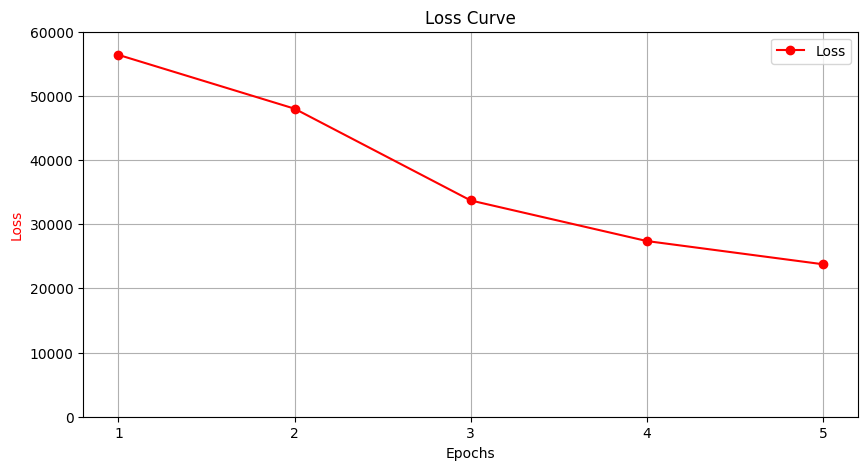

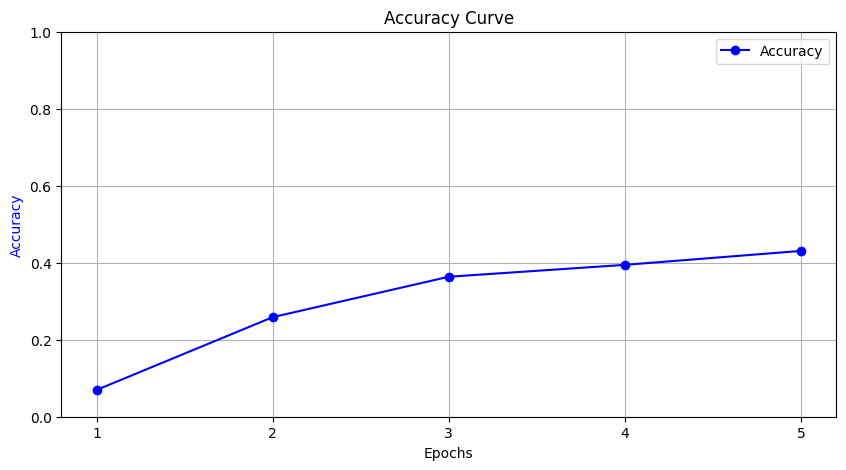

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3, 4, 5]  # Starting from epoch 1
loss = [56395.63671875, 48008.11328125, 33703.44140625, 27379.1875, 23762.279296875]
accuracy = [0.06945829179129247, 0.25855766035227445, 0.3635759388501133, 0.3944832170156165, 0.4307078763708837]

# Create a figure and axis for the loss curve
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, color='red', marker='o', linestyle='-', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss', color='red')
plt.title('Loss Curve')
plt.ylim(0, 60000)
plt.xticks(epochs)
plt.grid(True)
plt.legend()

# Create a separate figure and axis for the accuracy curve
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, color='blue', marker='o', linestyle='-', label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy', color='blue')
plt.title('Accuracy Curve')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.xticks(epochs)  # Set x-axis ticks to be the integer values
plt.grid(True)
plt.legend()

# Show the plots
plt.show()

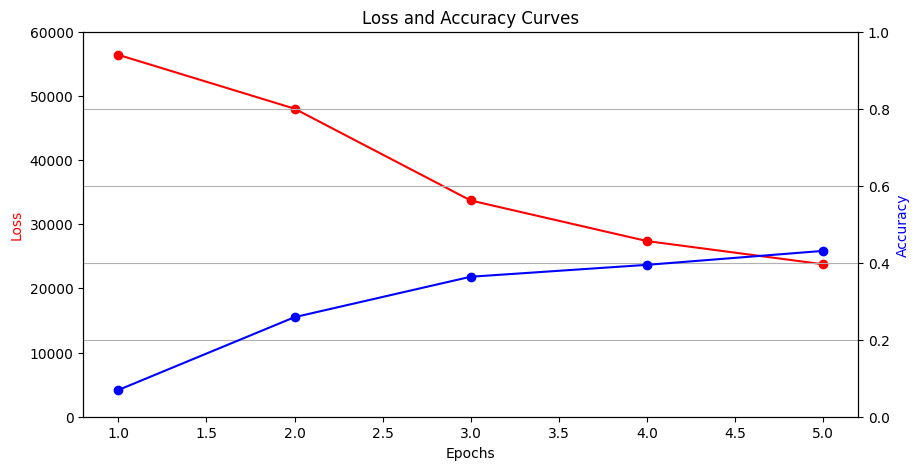

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3, 4, 5]  # Starting from epoch 1
loss = [56395.63671875, 48008.11328125, 33703.44140625, 27379.1875, 23762.279296875]
accuracy = [0.06945829179129247, 0.25855766035227445, 0.3635759388501133, 0.3944832170156165, 0.4307078763708837]

# Create a figure and axis for the combined plot
plt.figure(figsize=(10, 5))

# Plot the loss curve
plt.plot(epochs, loss, color='red', marker='o', linestyle='-', label='Loss')
plt.xlabel('Epochs')
plt.ylim(0, 60000)
plt.ylabel('Loss', color='red')

# Create a second y-axis for accuracy
ax2 = plt.twinx()
ax2.plot(epochs, accuracy, color='blue', marker='o', linestyle='-', label='Accuracy')
ax2.set_ylabel('Accuracy', color='blue')
ax2.set_ylim(0, 1)  # Set y-axis limits for accuracy

# Title and labels
plt.title('Loss and Accuracy Curves')
plt.grid(True)

# Show the plot
plt.show()